<a href="https://colab.research.google.com/github/taravatp/roadLane_InstanceSegmentation/blob/main/train/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Install required packages and import them

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Lane_Detection/

/content/drive/MyDrive/Lane_Detection


In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.1+cu102.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 3.0 MB 2.8 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 1.6 MB 2.6 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 926 kB 2.6 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1+cu102.html
     |████████████████████████████████| 390 kB 411 kB/s 
     |████████████████████████████████| 222 kB 5.2 MB/s 
     |████████████████████████████████| 376 kB 37.1 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.7.2-py3-none-any.whl size=388143 sha256=153fbb3421eaa31af8d8bc092e60e337706eca70de9512a50a2722b634facf45
  Stored in directory: /root/.cache/pip/wheels/55/93/b6/2eeb0465afe89aee74d7a07a606e9770466d7565abd45a99d5
Successfully built torch-

In [ ]:
!pip install import_ipynb 

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch_scatter
import numpy as np
import cv2
import os.path as ops
import time

import import_ipynb
from dataset.dataset_utils import TUSIMPLE
from models.model1_TuSimple import Lanenet

OSError: ignored

In [ ]:
print(torch.__version__)
print(torch.version.cuda)

1.9.0+cu102
10.2


# Loading Data

In [ ]:
root = 'TUSMIPLE/txt_for_local'
train_set = TUSIMPLE(root=root, flag='train')
valid_set = TUSIMPLE(root=root, flag='valid')
test_set = TUSIMPLE(root=root, flag='test')

batch_size = 16
data_loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
data_loader_valid = DataLoader(valid_set, batch_size=1, shuffle=True, num_workers=0)
data_loader_test = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

# Define Loss Function

In [ ]:
import torch
import torch.nn as nn
# from torch_scatter import scatter

class cluster_loss(nn.Module):
  def __init__(self):
    super(cluster_loss, self).__init__()

  def forward(self, binary_preds, binary_labels,instance_embedding_preds, instance_labels, delta_v=0.5, delta_d=3):
    binary_segmenatation_loss = self.binary_loss(binary_preds, binary_labels)
    instance_segmenatation_loss = self.instance_segmenatation_loss(instance_embedding_preds, instance_labels, delta_v=0.5, delta_d=3)
    return binary_segmenatation_loss.to(device),instance_segmenatation_loss.to(device)

  def binary_loss(self, binary_preds, binary_labels):
    # Since the two classes (lane/background) are highly unbalanced, we apply bounded inverse class weighting
    output, counts = torch.unique(binary_labels, return_inverse=False, return_counts=True)
    counts = counts.float()
    inverse_weights = torch.div(1.0, torch.log(torch.add(torch.div(counts, torch.sum(counts)), torch.tensor(1.02, dtype=torch.float))))
    binary_loss = torch.nn.CrossEntropyLoss(weight=inverse_weights)
    binary_segmenatation_loss = binary_loss(binary_preds, binary_labels)
    return binary_segmenatation_loss


  def instance_segmenatation_loss(self,instance_embedding_preds, instance_labels, delta_v=0.5, delta_d=3):
    batch_size = instance_embedding_preds.shape[0]
    instance_segmenatation_loss = torch.tensor(0.).to(device)
    for dimen in range(batch_size):
        prediction = torch.unsqueeze(instance_embedding_preds[dimen], 0) # .cuda() (4,256,512)=>(1,4,256,512)
        correct_label = torch.unsqueeze(instance_labels[dimen], 0)# .cuda() (256,512)=>(1,256,512)
        instance_segmenatation_loss += self.dicriminative_loss(prediction, correct_label, delta_v, delta_d)
    instance_segmenatation_loss = instance_segmenatation_loss / batch_size
    return instance_segmenatation_loss


  def dicriminative_loss(self,prediction, correct_label, delta_v, delta_d):
    
    prediction_reshape = prediction.view(prediction.shape[0], prediction.shape[1],prediction.shape[2] * prediction.shape[3])  # [N, 4, 131072]
    correct_label_reshape = correct_label.view(correct_label.shape[0], 1,correct_label.shape[1] * correct_label.shape[2])  # [N, 1, 131072]
     
    output, inverse_indices, counts = torch.unique(correct_label_reshape, return_inverse=True,return_counts=True)
    counts = counts.float() #number of elements in each instance
    num_instances = len(output) #number of instances 
    muc = scatter(prediction_reshape, inverse_indices, dim=2, reduce="mean")  # [N, 4, 5] bode sevom barabare tedade instance ha ast

    # Calculate l_var
    dis = torch.index_select(muc, 2, inverse_indices.view(inverse_indices.shape[-1]),out=None)  # [N, 4, 131072]
    dis = dis - prediction_reshape
    dis = torch.norm(dis, dim=1, keepdim=False, out=None, dtype=None)  # [N, 131072]
    dis = dis - delta_v
    dis = torch.clamp(dis, min=0.)  # [N, 131072]
    dis = torch.pow(dis, 2, out=None)

    L_var = scatter(dis, inverse_indices.view(inverse_indices.shape[-1]), dim=1, reduce="mean")  # [N, 3]
    L_var = torch.sum(L_var) / num_instances

    # Calculate l_dist
    L_dist = torch.tensor(0, dtype=torch.float)
    for A in range(num_instances):
        for B in range(num_instances):
            if A != B:
                dis = muc[:, :, A] - muc[:, :, B]
                dis = torch.norm(dis, dim=1, keepdim=False, out=None, dtype=None)
                dis = delta_d - dis
                dis = torch.clamp(dis, min=0.)
                dis = torch.pow(dis, 2, out=None)
                L_dist = L_dist + dis
    L_dist = L_dist / (num_instances * (num_instances - 1))
    L_dist = L_dist.view([])

    discriminative_loss = L_var + L_dist
    return discriminative_loss

# Model - Optimizer - Hyperparameters

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
LaneNet_model = Lanenet(2, 4)
LaneNet_model.to(device)

learning_rate = 5e-4
params = [p for p in LaneNet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=0.0002)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

loss_function = cluster_loss()
num_epochs = 5

# Training

In [ ]:
from torch.autograd import Variable

In [ ]:
loss_all = []
for epoch in range(num_epochs):
    LaneNet_model.train()
    ts = time.time()
    for iter, batch in enumerate(data_loader_train):
        input_image = Variable(batch[0]).to(device)
        binary_labels = Variable(batch[1]).to(device)
        instance_labels = Variable(batch[2]).to(device)

        binary_preds, instance_embedding_preds = LaneNet_model(input_image)
        #your loss function should take variables as input in order to be able to backpropagate!
        binary_segmenatation_loss, instance_segmenatation_loss = loss_function(binary_preds=binary_preds, binary_labels=binary_labels,
                                       instance_embedding_preds=instance_embedding_preds, instance_labels=instance_labels, delta_v=0.5, delta_d=3)
        loss = (1*binary_segmenatation_loss + 1*instance_segmenatation_loss).to(device)
        optimizer.zero_grad()
        loss_all.append(loss.item())
        loss.backward()
        optimizer.step()
        if iter % 20 == 0:
            print("epoch[{}] iter[{}] binary segmentation loss:[{}] instance-segmentation-loss:[{}] ".format(epoch, iter, binary_segmenatation_loss.item(), instance_segmenatation_loss.item()))
    lr_scheduler.step()
    print("Finish epoch[{}], time elapsed[{}]".format(epoch, time.time() - ts))
    torch.save(LaneNet_model.state_dict(), f"mymodel{epoch}_batch_{8}.pth")
    



# Visualizations

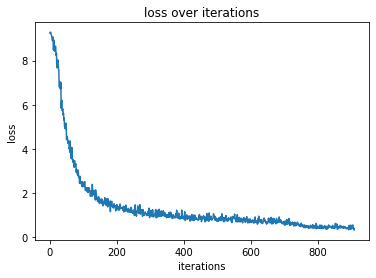

In [ ]:
import matplotlib.pylab as plt
%matplotlib inline
plt.title('loss over iterations')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(loss_all)

In [ ]:
import torch
x = torch.tensor([1,1,1,2,2,3,4,1,2,3])
output, inverse_indices, counts = torch.unique(x, return_inverse=True,return_counts=True)


In [ ]:
print(output)

tensor([1, 2, 3, 4])


In [ ]:
print(counts)

tensor([4, 3, 2, 1])


In [ ]:
print(inverse_indices)

tensor([0, 0, 0, 1, 1, 2, 3, 0, 1, 2])


In [ ]:
muc = scatter(prediction_reshape, inverse_indices, dim=2, reduce="mean")  # [N, 4, 5] bode sevom barabare tedade instance ha ast
print(muc)

NameError: ignored

In [ ]:
import torch_scatter

OSError: ignored

In [ ]:
flattened_prediction = prediction.view(prediction.shape[0], prediction.shape[1],prediction.shape[2] * prediction.shape[3])  # [batch_size, 4, H*W]
flattened_label = label.view(correct_label.shape[0], 1,correct_label.shape[1] * correct_label.shape[2])  # [batch_size, 1, H*W]